# How to identify outliers ?

This short notebook aim to cover some ideas to flag **outliers**. An outlier is an observation in a dataset that stands out of the distribution of the dataset. It could be an error (someone who's age is 200) or an anomaly. Some of these outliers are harmless and others could force an model too much so that its performance is not optimal.

This notebook doesn't cover all the possibilities and doesn't perform proper cleaning nor feature engineering. The only purpose is pedagogical on the outlier concept.

## Motivationnal example

To catch on the issue of having outliers, we start with a toy dataset and a linear regression. From only one random feature we build linearly a target and change only one point to make it out of distribution.

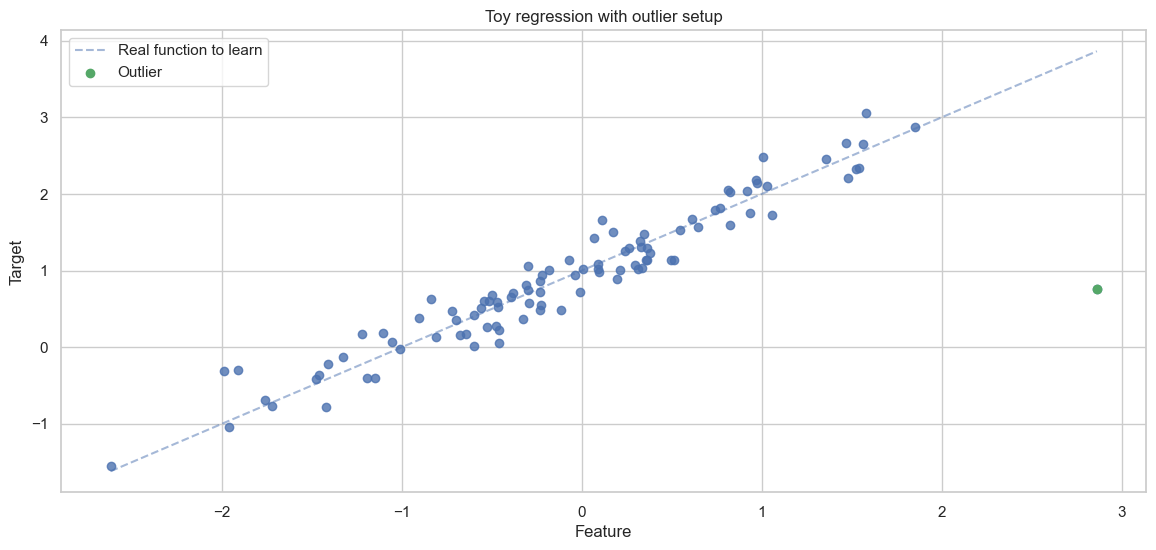

In [1]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
%matplotlib inline

size = 100
sigma = 0.25
function_real = lambda x: x + 1

x = np.random.normal(size=size)
y = function_real(x) + sigma * np.random.normal(size=size)

offset = 3
random_index = np.random.randint(0, size)
x[random_index] = x[random_index] + offset

x_range = np.array([np.min(x), np.max(x)])

plt.figure(figsize=(14, 6))
plt.plot(x_range, function_real(x_range), ls='--', alpha=0.5, color=sns.color_palette()[0], label="Real function to learn")
plt.scatter(x, y, alpha=0.8, color=sns.color_palette()[0])
plt.scatter(x[random_index], y[random_index], color=sns.color_palette()[2], label="Outlier")

plt.title("Toy regression with outlier setup")
plt.ylabel("Target")
plt.xlabel("Feature")
plt.legend()
plt.show()

Let's train a linear regression to find the best parameters. We expect the line learned to tend to the outlier, thus not being the optimal.

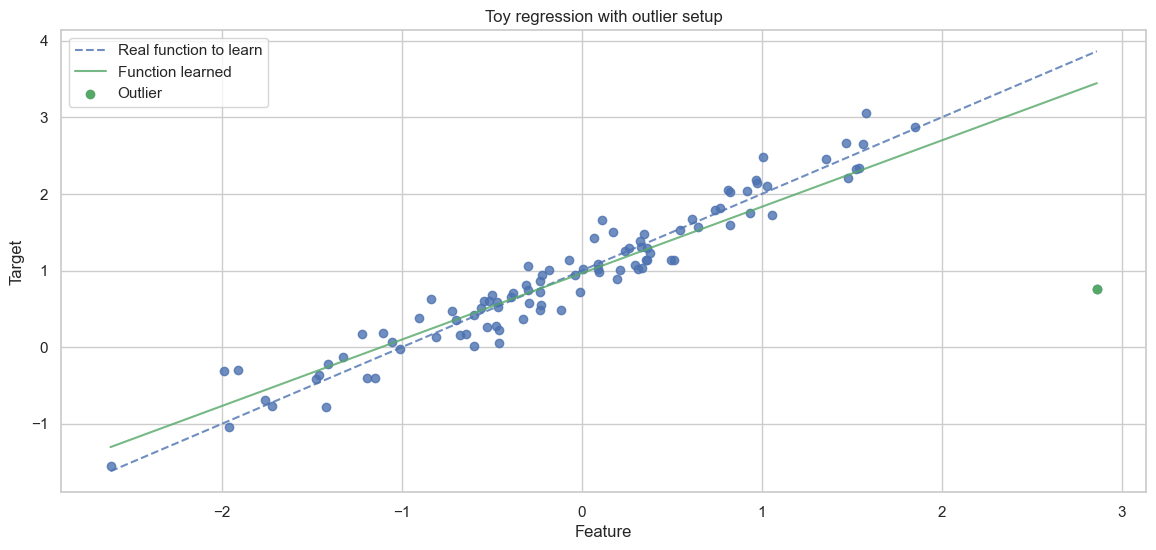

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x.reshape(-1, 1), y)
function_learned = lambda x: model.coef_[0] * x + model.intercept_

plt.figure(figsize=(14, 6))
plt.plot(x_range, function_real(x_range), ls='--', alpha=0.8, color=sns.color_palette()[0], label="Real function to learn")
plt.plot(x_range, function_learned(x_range), alpha=0.8, color=sns.color_palette()[2], label="Function learned")
plt.scatter(x, y, alpha=0.8)
plt.scatter(x[random_index], y[random_index], color=sns.color_palette()[2], label="Outlier")

plt.title("Toy regression with outlier setup")
plt.ylabel("Target")
plt.xlabel("Feature")
plt.legend()
plt.show()

As expected, the best line is not the real one and bend toward the outlier. Its weight, even if being slightly out of distribution, change the shape of predictions.

In [3]:
real_coefficients = np.array([1, 1])
learned_coefficients = np.array([model.coef_[0], model.intercept_])

print("Parameters (approximation)")
print(f"Real:\t\ty = {real_coefficients[0]:.2f}x + {real_coefficients[1]:.2f}")
print(f"Learned:\ty = {learned_coefficients[0]:.2f}x + {learned_coefficients[1]:.2f}")

Parameters (approximation)
Real:		y = 1.00x + 1.00
Learned:	y = 0.87x + 0.97


The performance on a test dataset would be better if the outlier was removed because it is out of distribution. Let's take a more realistic dataset on a crucial question for millenials : what is the price of an avocado ?

Extracted from the Hass Avocado Board website in May of 2018, one can find the [dataset](https://www.kaggle.com/datasets/neuromusic/avocado-prices) we will be working on. As we are not going deeper in the understanding of the dataset, we let the reader follow the link to get the description of the dataset.

In [5]:
import pandas as pd

df = pd.read_csv("Outliers - avocado.csv")
df = df.drop(columns=["Unnamed: 0", "year", "type", "region"])
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0


## Identify outliers

Before acting on outliers, we need to identify them. We are going to cover some statistical methods :
1. **Univariate methods** : Z-Score and Interquartile range
2. **Multivariate method** : Mahalanobis distance
3. **Anomaly detection** : Isolation Forest algorithm

But first, lets inspect visually the dataset.

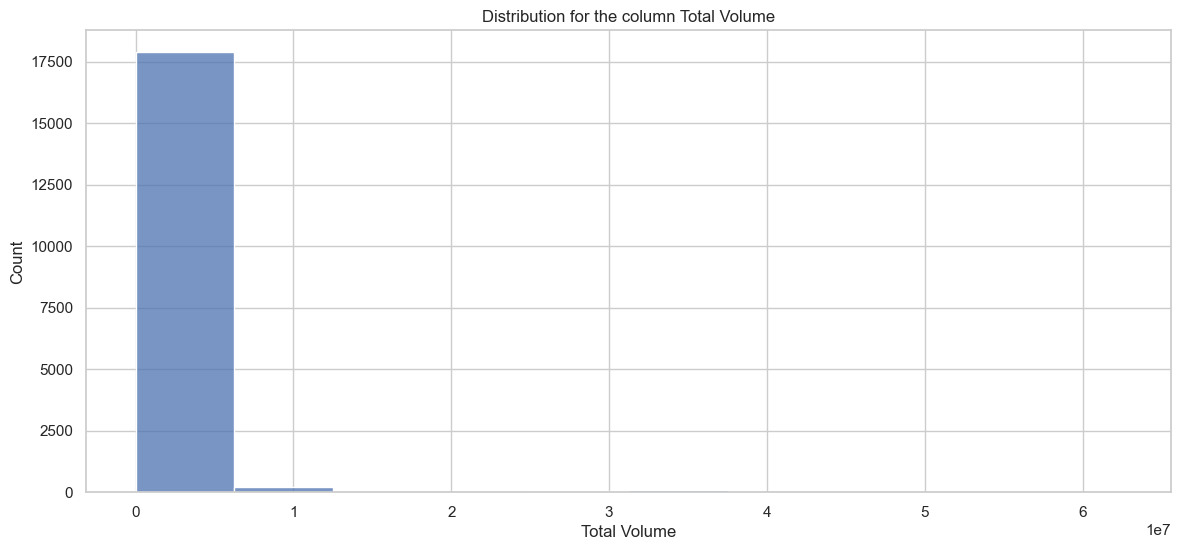

In [6]:
column = "Total Volume"

plt.figure(figsize=(14, 6))
sns.histplot(df[column], bins=10)
plt.title(f"Distribution for the column {column}")
plt.show()

The shape of the distribution tells us the presence of at least one outliers in this specific column. Indeed, the distribution seems to be highly concentrated, we can't see any *shape* but a rectangle. Let's see if these outliers are in or out of the distribution.

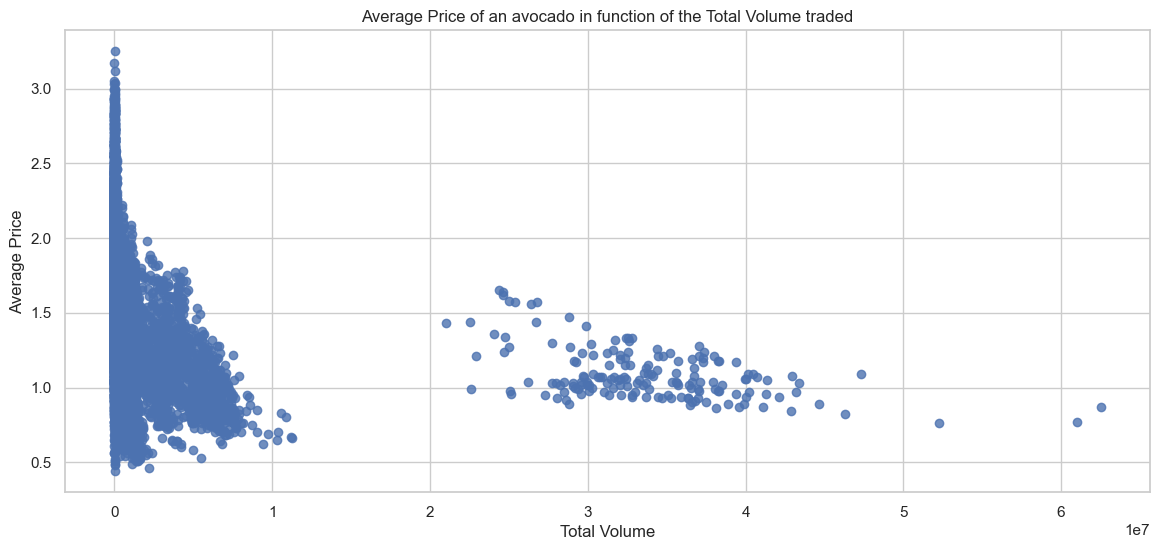

In [7]:
column = "Total Volume"

plt.figure(figsize=(14, 6))
plt.scatter(df[column], df["AveragePrice"], alpha=0.8)
plt.title(f"Average Price of an avocado in function of the {column} traded")
plt.xlabel(column)
plt.ylabel("Average Price")
plt.show()

The vast majority of observations are stacked, but some observations are way further. Also, they follow another trend than the first group of observations : they are going to be harmful to the model. If they were following the same trend, then they might not be too harmful to the model. We advise the reader to check these assumptions for each dataset one is working on.

The dataset exhibit outliers that one can identify visually, let's check if statistical methods catch them too.

### Z-Score

Given a vector $v$, one can compute its mean and standard deviation. From there, we define the Z-Score for a single observation $x$, based on the previous statistics:

$$ \text{Z-Score}(x) = \frac{x-\overline{v}}{\sigma(v)}$$

If the Z-Score is above $3$, then it means that the value of the observation $x$ is above the means by three times the *normal* variations. If the vector $v$ follows a normal distribution, then this observation is expected to be above 95% of the rest of the observations.

One use the Z-Score by setting a threshold (named here *alpha*) to identify potential outliers. Note that we should take it in absolute value.

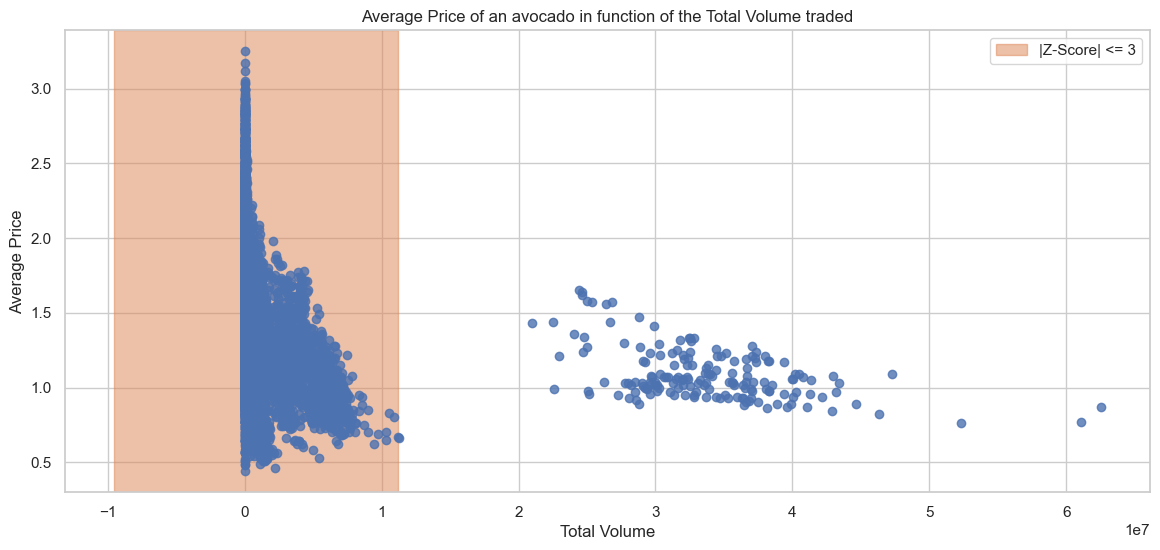

In [8]:
column = "Total Volume"
mean, std = df[column].mean(), df[column].std()
alpha = 3
threshold_down, threshold_up = mean - alpha * std, mean + alpha * std

plt.figure(figsize=(14, 6))
plt.axvspan(threshold_down, threshold_up, alpha=0.5, color=sns.color_palette()[1], label=f"|Z-Score| <= {alpha}")
plt.scatter(df[column], df["AveragePrice"], alpha=0.8)

plt.title(f"Average Price of an avocado in function of the {column} traded")
plt.xlabel(column)
plt.ylabel("Average Price")
plt.legend()
plt.show()

The paramater *alpha* is mostly set at 3 or 5 because of the interpretation in the case where the values follow a normal distribution.
With the Z-Score, outliers are all the observations with Z-Score above the threshold.

### Interquartile range

In the same spirit as the Z-Score, interquartile range is defined with the following statistics :
* Q1: first quartile of the distribution
* Q3: third quartile of the distribution
* IQR = Q3 - Q1 : interquartile range

Then, all the observations outside the interval [Q1-1.5IQR, Q3+1.5IQR] are considered as outliers. Visually :

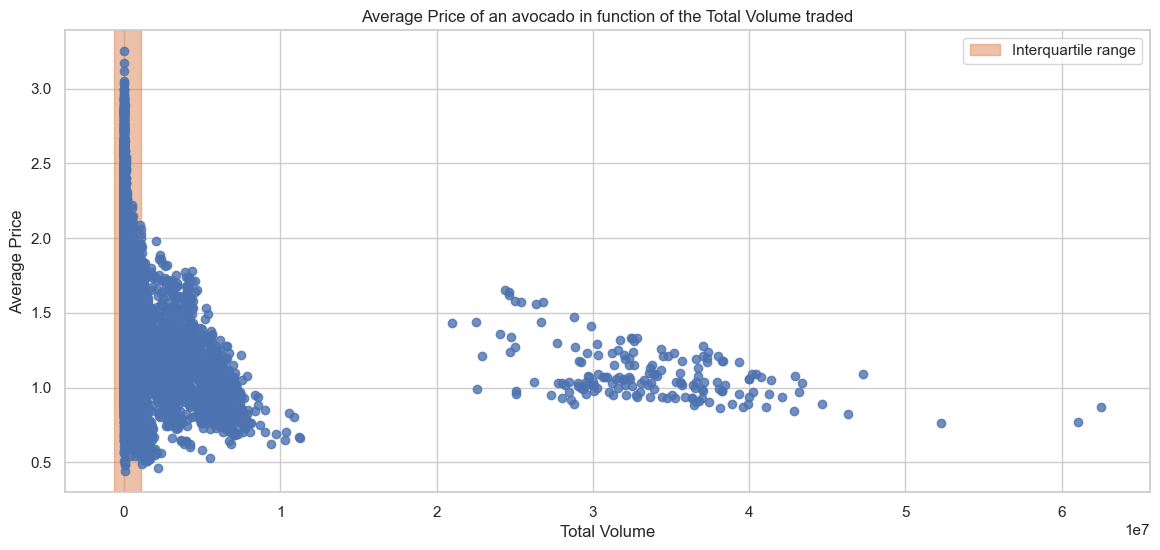

In [9]:
column = "Total Volume"
Q1, Q3 = np.percentile(df[column], 25), np.percentile(df[column], 75)
IQR = Q3-Q1
threshold_down, threshold_up = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

plt.figure(figsize=(14, 6))
plt.axvspan(threshold_down, threshold_up, alpha=0.5, color=sns.color_palette()[1], label=f"Interquartile range")
plt.scatter(df[column], df["AveragePrice"], alpha=0.8)

plt.title(f"Average Price of an avocado in function of the {column} traded")
plt.xlabel(column)
plt.ylabel("Average Price")
plt.legend()
plt.show()

This method create a narrower interval than the Z-Score : it means most of the observations are highly concentrated in our example.

To prepare for the next part of the notebook, we implement a function that take a dataset and identify all the rows where at least for one column the observation is an outlier to the Z-Score, and another for the interquartile range.

In [10]:
def z_score_identifier(dataset, level=3):
    matrix = np.abs((dataset - dataset.mean(axis=0)) / dataset.std(axis=0))
    indexes = matrix.loc[matrix.max(axis=1) > level, ].index
    return indexes

In [11]:
def interquartile_range(dataset):
    matrix = dataset.copy()
    for column in matrix.columns:
        Q1, Q3 = np.percentile(matrix[column], 25), np.percentile(matrix[column], 75)
        IQR = Q3-Q1
        threshold_down, threshold_up = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        matrix[column] = matrix[column].apply(lambda value: not(threshold_down <= value <= threshold_up))
    indexes = matrix.loc[matrix.max(axis=1), ].index
    return indexes

So far, the methods works *column by column* : outliers are not seek *globally* through all the columns.

### Mahalanobis distance : how far is the observation to the *rest* ?

The Mahalanobis adress this weakness by looking at the all the dimension at once. Formally, for a dataset $\mathcal{D}$ with mean vector $\overrightarrow{\mu}$ and covariance matrix $\Sigma$, the distance of an observation $x$ from $\mathcal{D}$ is :

$$d_M(x, \mathcal{D}) = \sqrt{(\overrightarrow{x}-\overrightarrow{\mu})^t\Sigma^{-1}(\overrightarrow{x}-\overrightarrow{\mu})}$$

To better understand what's at stake, by the [spectral theorem](https://en.wikipedia.org/wiki/Spectral_theorem), $\Sigma^{-1}$ can be decomposed as $\Sigma^{-1} = M^TM$ thus :

$$d_M(x, \mathcal{D}) = \|M(\overrightarrow{x}-\overrightarrow{\mu})\|_2$$

One can understand the Mahalanobis distance as the euclidean distance after a whitening transformation : $\mathcal{D}$ is linearly transformed so that $\overrightarrow{\mu}=\overrightarrow{0}$ and $\Sigma=I_d$.

If $\mathcal{D}$ with $K$ columns follows a normal distribution, then the Mahalanobis distance follows a $\chi^2$ distribution with $K$ degrees of freedom. Then, to identify outliers one can compute the Mahalanobis distance and set the threshold with a quantile of the $\chi^2_K$ distribution.

In [12]:
from scipy.stats import chi2

def mahalanobis_distance(dataset: pd.DataFrame, level=0.001) -> list:
    mean = dataset.mean(axis=0)
    centered = dataset - mean
    covariance = np.cov(centered.values.T)
    inverse_covariance = np.linalg.inv(covariance)
    distances_squared = np.array([np.matmul(np.matmul(row.T, inverse_covariance), row) for index, row in centered.iterrows()])
    distances = np.sqrt(distances_squared)

    threshold = np.sqrt(chi2.ppf((1 - level), df=dataset.shape[1]))
    outliers_index = [index for (index, distance) in enumerate(distances) if distance > threshold]
    return outliers_index

The function returns the index of the identified outilers. Let's apply it to our dataset :

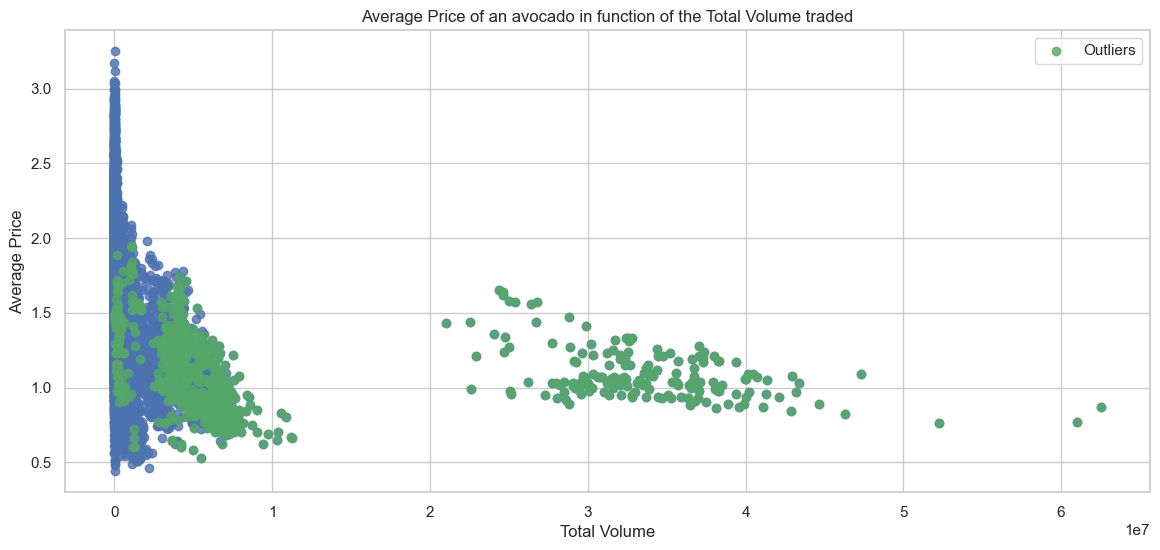

In [13]:
X = df.drop(columns=["Date", "AveragePrice"])
index = mahalanobis_distance(X, level=0.0001)

column = "Total Volume"
plt.figure(figsize=(14, 6))
plt.scatter(df[column], df["AveragePrice"], alpha=0.8)
plt.scatter(df.iloc[index, ][column], df.iloc[index, ]["AveragePrice"], alpha=0.8, color=sns.color_palette()[2], label="Outliers")

plt.title(f"Average Price of an avocado in function of the {column} traded")
plt.xlabel(column)
plt.ylabel("Average Price")
plt.legend()
plt.show()

The outliers for this specific column are well identified, but some other in the *pack* are also identified that wouldn't have been flagged using only the Z-Score on this feature.

### Isolation Forest : outlier as an anomaly

Another option to look globally at the dataset is to use the [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) algorithm. Unlike the previous methods, which rely on statistical measures or distance metrics, the Isolation Forest algorithm is based on the principle that outliers are fewer and easier to isolate. It randomly partitions the data using decision trees, and a data point's anomaly score is derived from the average path length across these trees to isolate the point.

Let's have a look :

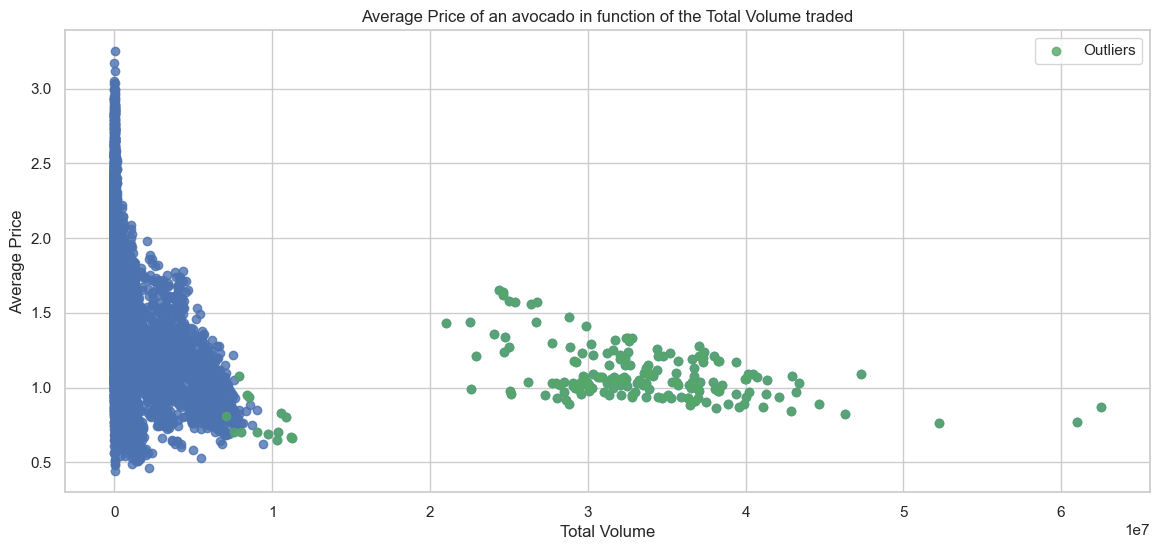

In [14]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.01)
X = df.drop(columns=["Date", "AveragePrice"])
predictions = model.fit_predict(X)
index = df.iloc[predictions == -1, ].index

column = "Total Volume"
plt.figure(figsize=(14, 6))
plt.scatter(df[column], df["AveragePrice"], alpha=0.8)
plt.scatter(df.iloc[index, ][column], df.iloc[index, ]["AveragePrice"], alpha=0.8, color=sns.color_palette()[2], label="Outliers")

plt.title(f"Average Price of an avocado in function of the {column} traded")
plt.xlabel(column)
plt.ylabel("Average Price")
plt.legend()
plt.show()

Again, for the next part of the notebook we implement a function to use this method to flag outliers.

In [15]:
def isolation_forest_identifier(dataset, contamination=0.01):
    model = IsolationForest(n_estimators=100, contamination=contamination)
    predictions = model.fit_predict(dataset)
    indexes = dataset.iloc[predictions == -1, ].index
    return indexes

One could also do the same job as the isolation forest using the [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm !

## Performance comparison using a Linear Regression

With several methods to identify outliers, one need to take actions. There are some options to handle outliers, but we are only considering here removing outliers.

As all the previous methods work on a dataset to flag observations, we are going to build first a general function :

In [16]:
def remove_outliers(dataset, indexes):
    return dataset.drop(index=indexes)

We are going to train several models (all linear regressions) with different dataset where outliers were removed with variations of the presented methods.
To do so, we need :
1. A dataset for training and a dataset to measure performance : since the dataset is indexed by time, a random split won't work here
2. A metric to compare : we choose to work with RMSE

In [17]:
from sklearn.metrics import mean_squared_error

def RMSE(y_true: np.array, y_pred: np.array) -> float:
    MSE = mean_squared_error(y_true=y_true, y_pred=y_pred)
    return np.sqrt(MSE)



def historical_train_test(dataset: pd.DataFrame, target_column: str, date_column: str, train_ratio=0.75):
    dataset = dataset.copy().sort_values(by=date_column, inplace=False)
    index = int(dataset.shape[0] * train_ratio)
    X = dataset.drop(columns=[target_column, date_column], axis=1)
    y = dataset[target_column]
    
    X_train, X_test = X.iloc[:index, ], X.iloc[index:, ]
    y_train, y_test = y[:index], y[index:]
    
    for element in [X_train, X_test, y_train, y_test]:
        element.reset_index(inplace=True, drop=True)
    return X_train, X_test, y_train, y_test

We will now compare the following method :
1. **Z-Score** : with level 1, 3 and 5 using the `z_score_identifier` function
2. **Mahalanobis distance** : with confidence 1%, 0.5% and 0.01% using the `mahalanobis_distance` function
3. **Isolation Forest** : with contamination 1%, 0.5% and 0.01% using the `isolation_forest_identifier` function

Since the loop for the three methods will be similar, we write a function.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def train_model(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("linear", LinearRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    performance = RMSE(y_test, y_pred)
    return performance



def comparison_loop(dataset: pd.DataFrame, outlier_identifier, values: list) -> None:
    for value in values:
        X_train, X_test, y_train, y_test = historical_train_test(dataset=dataset, target_column="AveragePrice", date_column="Date")

        outliers_indexes = outlier_identifier(X_train, value)
        row_before = X_train.shape[0]
        X_train = remove_outliers(X_train, outliers_indexes)
        y_train = remove_outliers(y_train, outliers_indexes)
        row_after = X_train.shape[0]
        reduction = 100 * (row_after - row_before) / row_before
        performance = train_model(X_train, X_test, y_train, y_test)

        print(f"Parameter={value}:\tReduction={reduction:0.2f}%\tRMSE={performance:0.2f}")

Before we compare, let's have a look at the performance for a naive Linear Regression :

In [19]:
dataset = df.copy()
X_train, X_test, y_train, y_test = historical_train_test(dataset=dataset, target_column="AveragePrice", date_column="Date")
performance = train_model(X_train, X_test, y_train, y_test)
print(f"RMSE={performance:0.2f}")

RMSE=15.21


Let's compare !

In [20]:
np.seterr(invalid='ignore')
print("Z-score: Parameter is the value of the Z-score")
comparison_loop(dataset, z_score_identifier, [1, 3, 5])

print()
print("Mahalanobis distance: parameter is the quantile")
comparison_loop(dataset, mahalanobis_distance, [0.01, 0.005, 0.001])

print()
print("Isolation Forest: parameter is the contamination")
comparison_loop(dataset, mahalanobis_distance, [0.01, 0.005, 0.001])

Z-score: Parameter is the value of the Z-score
Parameter=1:	Reduction=-8.99%	RMSE=8.65
Parameter=3:	Reduction=-2.50%	RMSE=13.85
Parameter=5:	Reduction=-1.26%	RMSE=14.45

Mahalanobis distance: parameter is the quantile
Parameter=0.01:	Reduction=-5.32%	RMSE=0.87
Parameter=0.005:	Reduction=-5.06%	RMSE=0.85
Parameter=0.001:	Reduction=-4.44%	RMSE=0.75

Isolation Forest: parameter is the contamination
Parameter=0.01:	Reduction=-5.32%	RMSE=0.87
Parameter=0.005:	Reduction=-5.06%	RMSE=0.85
Parameter=0.001:	Reduction=-4.44%	RMSE=0.75


All methods improved the baseline, with a stable ~2% gain. The Z-Score (parameter=1) achieved the lowest RMSE (8.65) but was too strict, significantly reducing the dataset.
For this dataset, we recommend Mahalanobis distance or Isolation Forest for their consistent, robust performance. Note these two methods likely identified the same outliers !



## Limitations of the notebook

As we come to an end of this notebook, it is important to keep in mind the following limitations :
1. We blindly removed outliers as defined by the methods. One should inspect visually what's at stake for each of them.
2. One can combine the methods to build a *score* of outliers and then decide which outliers to remove.
3. We decided to remove, but one can also modify the values of an outliers : to its mean/median or by [winsorizing](https://en.wikipedia.org/wiki/Winsorizing). Then, one must be very careful on all the choice to be made.
4. We worked on only one dataset for one task, and measured performance with one metric for one algorithm.

Thus, **this notebook doesn't hold any absolut truth** but implement some methods to try and adapt to one's tasks.